# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Aprendizaje por refuerzos

### Trabajo práctico entregable 2/2 (materia completa)

**Estudiante:**
- [Chevallier-Boutell, Ignacio José.](https://www.linkedin.com/in/nachocheva/)

**Docentes:**
- Palombarini, Jorge (Mercado Libre).
- Barsce, Juan Cruz (Mercado Libre).

---

## Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces

import time

# from stable_baselines3.common.env_checker import check_env

# Traemos las funciones ya definidas y utilizadas en el primer laboratorio
from utyls_RL import *
%load_ext autoreload
%autoreload 2

Para ver los videos de las ejecuciones hay que tener instalado ffmpeg (`apt-get install ffmpeg`).

---
# Ejercicio 1

Crear un entorno propio y entrenar agentes de RL en el mismo, utilizando diferentes algoritmos.

## Cheva's Odyssey: reglas del juego

El mapa del juego consiste en una grilla 6x6, como se muestra a continuación. Al comenzar un episodio, el agente se ubica en la posición $S$ (elemento [5, 5]) y debe llegar hasta $G$ (elemento [0, 2]) para terminar dicho episodio. El agente debe realizar tantos movimientos como sean necesarios para llegar a la meta y finalizar el episodio.

|J|A|G|A|~|~|
|-|-|-|-|-|-|
|~|A|A|A|~|~|
|~|~|~|~|~|~|
|~|~|~|~|~|~|
|A|A|~|~|~|~|
|P|A|~|~|~|S|

El espacio de estados $\mathcal{S}$ tiene 36 elementos. Para calcular el valor del estado asociado a cada elemento del mapa debemos calcular
    $$\text{Fila Actual} \times \text{Número de Columnas} + \text{Columna Actual}$$

donde debemos contar desde 0. De esta manera, el estado inicial $S$ es el estado 35 y el estado terminal $G$ es el estado 2.

El espacio de acciones $\mathcal{A}$ tiene 4 elementos para todos los estados que no están en el borde del mapa:
- 0 $\Rightarrow$ Se mueve hacia arriba.
- 1 $\Rightarrow$ Se mueve hacia la derecha.
- 2 $\Rightarrow$ Se mueve hacia abajo.
- 3 $\Rightarrow$ Se mueve hacia la izquierda.

Para los estados que están en los bordes, sólo se puede elegir entre 2 acciones si están en los vértices o entre 3 si están en las aristas, según corresponda. Observamos que se cumple que $\mathcal{A}, \mathcal{S} \in \mathbb{N}$.

Además de la salida $S$ y la meta $G$, tenemos otros elementos en el mapa. Los elementos vacíos (~) representan pasto, mientras que los elementos con $A$ son agua. El elemento $J$ es un jetpack y el elemento $P$ representa un premio extra. A partir de esto, la función de recompensa es tal que el agente recibe:
- $-1$ cuando ingresa en a un elemento con pasto o cuando busca el jetpack o el premio extra. Sus efectos no se pierden, pero tampoco se acumulan.
- $-8$ cuando ingresa en a un elemento con agua. En caso de contar con el jetpack, el costo por pasar por el agua se reduce a $-2$.
- $+0$ si alcanza la meta sin el premio extra y $+24$ cuando la alcanza con el premio extra.

Hay principalmente 5 caminos relevantes:
- **SG:** Ir directo a la meta requiere 8 pasos temporales, otorgando -14 puntos.
- **SJG:** Buscar el jetpack e ir a la meta requiere 12 pasos temporales, otorgando -12 puntos.
- **SPG:** Buscar el premio extra e ir a la meta requiere 12 pasos temporales, otorgando -8 puntos.
- **SPJG:** Buscar el premio extra, luego el jetpack e ir a la meta requiere 12 pasos temporales, otorgando -2 puntos.
- **SJPG:** Buscar el jetpack, luego el premio extra e ir a la meta requiere 22 pasos temporales, otorgando 0 puntos (puntuación máxima).

## Creación del agente

Creamos la clase del agente asociado al juego.

In [ ]:
class ChevasOdyssey(gym.Env):
    # Tipo de renderizado posible, además de None.
    metadata = {"render.modes": ["console"]}

    # Definimos los valores de las acciones
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3

    # Efectos del Jetpack y el premio
    JETPACK = 1
    PREMIO = 0

    def __init__(self):
        super(ChevasOdyssey, self).__init__()

        # Tamaño del mapa
        self.grid_shape = (6, 6)

        # Espacio de acciones
        self.action_space = spaces.Discrete(4)

        # Espacio de estados
        self.observation_space = spaces.Discrete(36)

        # Inicializamos en agente en la salida
        self.agent_pos = 35

        # Ubicamos el jetpack
        self.jetpack_pos = 0

        # Ubicamos el premio extra
        self.extra_pos = 30

        # Ubicamos la meta
        self.goal_pos = 2

        # Ubicamos el agua
        self.water_pos = [1, 3, 7, 8, 9, 24, 25, 31]

    def reset(self, seed=None) -> Tuple[np.array, dict]:
        """
        Reinicia el ambiente y devuelve la observación inicial
        """

        # Inicializamos en agente en el punto de partida
        self.agent_pos = 35

        self.JETPACK = 1
        
        self.PREMIO = 0

        return (self.agent_pos, {})

    def step(self, action):
        if action == self.UP:
            self.agent_pos -= 6
        elif action == self.RIGHT:
            self.agent_pos += 1
        elif action == self.DOWN:
            self.agent_pos += 6
        elif action == self.LEFT:
            self.agent_pos -= 1
        else:
            raise ValueError(
                f"Se recibió una acción inválida={action} que no es parte del\
                    espacio de acciones"
            )

        # Evitamos que el agente se salga de los límites de la grilla
        self.agent_pos = np.clip(self.agent_pos, 0, 36)

        # Consigue el jetpack
        if self.agent_pos == self.jetpack_pos:
            self.JETPACK = 4

        # Consigue el premio extra
        if self.agent_pos == self.extra_pos:
            self.PREMIO = 24

        # Llegada a la meta
        terminated = bool(self.agent_pos == self.goal_pos)
        truncated = False

        # Asignación de recompensa
        if self.agent_pos == self.goal_pos:
            reward = self.PREMIO
        elif self.agent_pos in  self.water_pos:
            reward = -8 / self.JETPACK
        else:
            reward = -1

        # Información adicional
        info = {}

        return (
            self.agent_pos,
            reward,
            terminated,
            truncated,
            info,
        )

    def render(self, mode="console"):
        print('Not implemented yet.')

    def close(self):
        pass

Validamos que el ambiente cumpla con la interfaz de gym. Si el entorno no cumple con la interfaz, se lanzará una excepción.

In [ ]:
# env = ChevasOdyssey()
# check_env(env, warn=True)

## Implementaciones

Se utilizan las 3 combinaciones que mejores resultados arrojaron en el primer laboratoio:
* SARSA con SoftMax.
* Q-learning con $\epsilon$-greedy.
* Dyna-Q.

In [ ]:
env = ChevasOdyssey()
actions = range(env.action_space.n)
max_iter = 1000

### SARSA con SoftMax

Run

In [ ]:
policy = SoftMax

# Me quedo con 100k donde ya estabiliza
Sw_eps = [100000] # [20000, 50000, 100000, 150000, 200000]
# Me quedo con 0.1
Sw_a = [0.1] # [0.05, 0.1, 0.15, 0.2, 0.25]
# Me quedo con 0.45
Sw_g = [0.45] # [0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.9, 1]
# Me quedo con 0.03. Me tira prob Nan con 0.005 y 0.01
Sw_t = [0.03] # [0.03, 0.05, 0.1, 0.5, 1]

for p_eps in Sw_eps:
    episodes_to_run = p_eps
    for p_a in Sw_a:
        for p_g in Sw_g:
            for p_t in Sw_t:
                hyperparameters = {
                    "alpha": p_a,
                    "gamma": p_g,
                    "tau": p_t,
                }

                random_state = np.random.RandomState(1994)

                start = time.time()
                ep_timesteps, ep_return, ep_goal, ep_drop, ep_early, q = run_SARSA(
                    policy,
                    hyperparameters,
                    episodes_to_run,
                    env,
                    actions,
                    random_state,
                    max_iter
                )
                WallTime = time.time() - start

                env.close()

                # Guardamos los resultados
                runType = f'SARSA-{policy.__name__}'
                runPar = f'its-{max_iter}_eps-{episodes_to_run}'
                runHPar = f'a-{hyperparameters["alpha"]}_g-{hyperparameters["gamma"]}_t-{hyperparameters["tau"]}'

                with open(f'Outputs/Lab2/{runType}/{runPar}_{runHPar}.csv', 'w') as f:
                    f.write('Goal\tDrop\tEarly\tTotal\n')
                    f.write(f'{ep_goal}\t{ep_drop}\t{ep_early}\t{episodes_to_run}\n')

                    f.write(f'Wall Time[s]\t{WallTime}\n')
                    
                    f.write('State\tAction\tQ-value\n')
                    for s in range(37):
                        for a in range(4):
                            f.write(f'{s}\t{a}\t{q[(s,a)]:.6f}\n')

                    f.write('Return\tTimeSteps\n')
                    for i in range(episodes_to_run):
                        f.write(f'{ep_return[i]:.0f}\t{ep_timesteps[i]:.0f}\n')

Plot

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))

# for p_a in [0.05, 0.1, 0.15, 0.2, 0.25]:
#     File = pd.read_csv(f'Outputs/Lab2/Dyna-Q/Alpha/its-1000_eps-20000_a-{p_a}_g-1_t-0.05.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)
#     axs[0].plot(mean_evol(File[:,0]), label=rf'$\alpha$ = {p_a}')
#     axs[1].plot(mean_evol(File[:,1]), label=rf'$\alpha$ = {p_a}')

# for p_g in [0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.9, 1]:
#     File = pd.read_csv(f'Outputs/Lab2/Q-learning-EpGreedy/Gamma/its-1000_eps-20000_a-0.1_g-{p_g}_t-0.05.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)
#     axs[0].plot(mean_evol(File[:,0]), label=rf'$\gamma$ = {p_g}')
#     axs[1].plot(mean_evol(File[:,1]), label=rf'$\gamma$ = {p_g}')

# for p_t in [0.03, 0.05, 0.1, 0.5, 1]:
#     File = pd.read_csv(f'Outputs/Lab2/Dyna-Q/Tau/its-1000_eps-20000_a-0.1_g-0.45_t-{p_t}.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)
#     axs[0].plot(mean_evol(File[:,0]), label=rf'$\tau$ = {p_t}')
#     axs[1].plot(mean_evol(File[:,1]), label=rf'$\tau$ = {p_t}')

for eps in [200000, 150000, 100000, 50000, 20000]:
    File = pd.read_csv(f'Outputs/Lab2/Dyna-Q/Episodios/its-1000_eps-{eps}_a-0.1_g-0.45_t-0.03.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)
    axs[0].plot(mean_evol(File[:,0]))
    axs[1].plot(mean_evol(File[:,1]))

axs[0].set_ylim(-30, 1)
axs[1].set_ylim(7, 38)

axs[0].axhline(-14, color='red', linestyle=':', label='SG')
axs[0].axhline(-12, color='blue', linestyle=':', label='SJG')
axs[0].axhline(-8, color='red', linestyle='-.', label='SPG')
axs[0].axhline(-2, color='blue', linestyle='-.', label='SPJG')
axs[0].axhline(0, color='black', linestyle='--', label='SJPG')

axs[0].set_xlabel('Episodios')
axs[1].set_xlabel('Episodios')

axs[1].axhline(8, color='red', linestyle=':', label='SG')
axs[1].axhline(12, color='blue', linestyle=':', label='SJG | SPG | SPJG')
axs[1].axhline(22, color='black', linestyle='--', label='SJPG')

axs[0].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

axs[0].set_ylabel('Retorno promedio')
axs[1].set_ylabel('Pasos temporales promedio')

axs[0].legend(loc='lower right', frameon=False, fancybox=True, title='Camino', ncol=2)
axs[1].legend(loc='upper right', frameon=False, fancybox=True, title='Camino', ncol=2)

# plt.savefig('Outputs/Lab2/Dyna-Q/Alpha/its-1000_eps-20000_g-1_t-0.05.png')
# plt.savefig('Outputs/Lab2/Dyna-Q/Gamma/its-1000_eps-20000_a-0.1_t-0.05.png')
# plt.savefig('Outputs/Lab2/Dyna-Q/Tau/its-1000_eps-20000_a-0.1_g-0.45.png')
plt.savefig('Outputs/Lab2/Dyna-Q/Episodios/its-1000_a-0.1_g-0.45_t-0.03.png')

### Dyna-Q y Q-learning con $\epsilon$-greedy

Cuando se quiera hacer Q-learning con $\epsilon$-greedy, se usa Dyna-Q con 0 pasos de planificación.

#### Q-learning con $\epsilon$-greedy

Run Q-learning

In [ ]:
policy = epGreedy

# Me quedo con 100k donde ya estabiliza
Sw_eps = [100000] # [20000, 50000, 100000, 150000, 200000]
# Me quedo con 0.1
Sw_a = [0.1] # [0.05, 0.1, 0.15, 0.2, 0.25]
# Me quedo con 0.65
Sw_g = [0.65] # [0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.9, 1]
# Me quedo con 0.001
Sw_e = [0.001] # [0.001, 0.005, 0.01, 0.05]
Sw_s = [0]

for p_eps in Sw_eps:
    episodes_to_run = p_eps
    for p_a in Sw_a:
        for p_g in Sw_g:
            for p_e in Sw_e:
                for p_s in Sw_s:
                    hyperparameters = {
                        "alpha": p_a,
                        "gamma": p_g,
                        "epsilon": p_e,
                        "steps": p_s
                    }
                    print(hyperparameters)

                    random_state = np.random.RandomState(1994)

                    start = time.time()
                    ep_timesteps, ep_return, ep_goal, ep_drop, ep_early, q = run_DynaQ(
                        policy,
                        hyperparameters,
                        episodes_to_run,
                        env,
                        actions,
                        random_state,
                        max_iter
                    )
                    WallTime = time.time() - start

                    env.close()

                    # Guardamos los resultados
                    runType = 'Q-learning-EpGreedy'
                    runPar = f'its-{max_iter}_eps-{episodes_to_run}'
                    runHPar = f'a-{hyperparameters["alpha"]}_g-{hyperparameters["gamma"]}_e-{hyperparameters["epsilon"]}'

                    with open(f'Outputs/Lab2/{runType}/{runPar}_{runHPar}.csv', 'w') as f:
                        f.write('Goal\tDrop\tEarly\tTotal\n')
                        f.write(f'{ep_goal}\t{ep_drop}\t{ep_early}\t{episodes_to_run}\n')

                        f.write(f'Wall Time[s]\t{WallTime}\n')
                        
                        f.write('State\tAction\tQ-value\n')
                        for s in range(37):
                            for a in range(4):
                                f.write(f'{s}\t{a}\t{q[(s,a)]:.6f}\n')

                        f.write('Return\tTimeSteps\n')
                        for i in range(episodes_to_run):
                            f.write(f'{ep_return[i]:.0f}\t{ep_timesteps[i]:.0f}\n')

Plot Q-learning

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_ylim(-30, 1)
axs[1].set_ylim(7, 38)

axs[0].axhline(-14, color='red', linestyle=':', label='SG')
axs[0].axhline(-12, color='blue', linestyle=':', label='SJG')
axs[0].axhline(-8, color='red', linestyle='-.', label='SPG')
axs[0].axhline(-2, color='blue', linestyle='-.', label='SPJG')
axs[0].axhline(0, color='black', linestyle='--', label='SJPG')

axs[0].set_xlabel('Episodios')
axs[1].set_xlabel('Episodios')

axs[1].axhline(8, color='red', linestyle=':', label='SG')
axs[1].axhline(12, color='blue', linestyle=':', label='SJG | SPG | SPJG')
axs[1].axhline(22, color='black', linestyle='--', label='SJPG')

axs[0].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

axs[0].set_ylabel('Retorno promedio')
axs[1].set_ylabel('Pasos temporales promedio')

# for p_a in [0.05, 0.1, 0.15, 0.2, 0.25]:
#     File = pd.read_csv(f'Outputs/Lab2/Q-learning-EpGreedy/Alpha/its-1000_eps-20000_a-{p_a}_g-1_e-0.05.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)
#     axs[0].plot(mean_evol(File[:,0]), label=rf'$\alpha$ = {p_a}')
#     axs[1].plot(mean_evol(File[:,1]), label=rf'$\alpha$ = {p_a}')

# for p_g in [0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.9, 1]:
#     File = pd.read_csv(f'Outputs/Lab2/Q-learning-EpGreedy/Gamma/its-1000_eps-20000_a-0.1_g-{p_g}_e-0.05.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)
#     axs[0].plot(mean_evol(File[:,0]), label=rf'$\gamma$ = {p_g}')
#     axs[1].plot(mean_evol(File[:,1]), label=rf'$\gamma$ = {p_g}')

# for p_e in [0.05, 0.01, 0.005, 0.001]:
#     File = pd.read_csv(f'Outputs/Lab2/Q-learning-EpGreedy/Epsilon/its-1000_eps-20000_a-0.1_g-0.65_e-{p_e}.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)
#     axs[0].plot(mean_evol(File[:,0]), label=rf'$\epsilon$ = {p_e}')
#     axs[1].plot(mean_evol(File[:,1]), label=rf'$\epsilon$ = {p_e}')

for eps in [200000, 150000, 100000, 50000, 20000]:
    File = pd.read_csv(f'Outputs/Lab2/Q-learning-EpGreedy/Episodios/its-1000_eps-{eps}_a-0.1_g-0.65_e-0.001.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)
    axs[0].plot(mean_evol(File[:,0]))
    axs[1].plot(mean_evol(File[:,1]))

axs[0].legend(loc='lower right', frameon=False, fancybox=True, title='Camino', ncol=2)
axs[1].legend(loc='upper right', frameon=False, fancybox=True, title='Camino', ncol=2)

# plt.savefig('Outputs/Lab2/Q-learning-EpGreedy/Alpha/its-1000_eps-20000_g-1_e-0.05.png')
# plt.savefig('Outputs/Lab2/Q-learning-EpGreedy/Gamma/its-1000_eps-20000_a-0.1_e-0.05.png')
# plt.savefig('Outputs/Lab2/Q-learning-EpGreedy/Epsilon/its-1000_eps-20000_a-0.1_g-0.65.png')
plt.savefig('Outputs/Lab2/Q-learning-EpGreedy/Episodios/its-1000_a-0.1_g-0.65_e-0.001.png')

#### Dyna-Q

Run Dyna-Q

In [40]:
policy = epGreedy

# Me quedo con 
Sw_eps = [20000] # [20000, 50000, 100000, 150000, 200000]
# Me quedo con 
Sw_a = [0.1] # [0.05, 0.1, 0.15, 0.2, 0.25]
# Me quedo con 
Sw_g = [1] # [0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.9, 1]
# Me quedo con 20000
Sw_e = [0.05] # [0.001, 0.005, 0.01, 0.05]
Sw_s = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for p_eps in Sw_eps:
    episodes_to_run = p_eps
    for p_a in Sw_a:
        for p_g in Sw_g:
            for p_e in Sw_e:
                for p_s in Sw_s:
                    hyperparameters = {
                        "alpha": p_a,
                        "gamma": p_g,
                        "epsilon": p_e,
                        "steps": p_s
                    }
                    print(hyperparameters)

                    random_state = np.random.RandomState(1994)

                    start = time.time()
                    ep_timesteps, ep_return, ep_goal, ep_drop, ep_early, q = run_DynaQ(
                        policy,
                        hyperparameters,
                        episodes_to_run,
                        env,
                        actions,
                        random_state,
                        max_iter
                    )
                    WallTime = time.time() - start

                    env.close()

                    # Guardamos los resultados
                    runType = f'Dyna-Q'
                    runPar = f'its-{max_iter}_eps-{episodes_to_run}'
                    runHPar = f'a-{hyperparameters["alpha"]}_g-{hyperparameters["gamma"]}_e-{hyperparameters["epsilon"]}_s-{hyperparameters["steps"]}'

                    with open(f'Outputs/Lab2/{runType}/{runPar}_{runHPar}.csv', 'w') as f:
                        f.write('Goal\tDrop\tEarly\tTotal\n')
                        f.write(f'{ep_goal}\t{ep_drop}\t{ep_early}\t{episodes_to_run}\n')

                        f.write(f'Wall Time[s]\t{WallTime}\n')
                        
                        f.write('State\tAction\tQ-value\n')
                        for s in range(37):
                            for a in range(4):
                                f.write(f'{s}\t{a}\t{q[(s,a)]:.6f}\n')

                        f.write('Return\tTimeSteps\n')
                        for i in range(episodes_to_run):
                            f.write(f'{ep_return[i]:.0f}\t{ep_timesteps[i]:.0f}\n')

{'alpha': 0.1, 'gamma': 1, 'epsilon': 0.05, 'steps': 10}
	# Episodios = 999 >>> Retorno = -8.0 | Tiempo = 0.15 min
	# Episodios = 1999 >>> Retorno = -8.0 | Tiempo = 0.29 min
	# Episodios = 2999 >>> Retorno = -8.0 | Tiempo = 0.41 min
	# Episodios = 3999 >>> Retorno = -8.0 | Tiempo = 0.53 min
	# Episodios = 4999 >>> Retorno = -10.0 | Tiempo = 0.66 min
	# Episodios = 5999 >>> Retorno = -8.0 | Tiempo = 0.79 min
	# Episodios = 6999 >>> Retorno = -8.0 | Tiempo = 0.91 min
	# Episodios = 7999 >>> Retorno = -8.0 | Tiempo = 1.04 min
	# Episodios = 8999 >>> Retorno = -8.0 | Tiempo = 1.15 min
	# Episodios = 9999 >>> Retorno = -8.0 | Tiempo = 1.28 min
	# Episodios = 10999 >>> Retorno = 14.0 | Tiempo = 1.40 min
	# Episodios = 11999 >>> Retorno = -9.0 | Tiempo = 1.52 min
	# Episodios = 12999 >>> Retorno = -8.0 | Tiempo = 1.64 min
	# Episodios = 13999 >>> Retorno = -13.0 | Tiempo = 1.76 min
	# Episodios = 14999 >>> Retorno = -8.0 | Tiempo = 1.88 min
	# Episodios = 15999 >>> Retorno = -8.0 | Tiempo = 2

Plot Dyna-Q

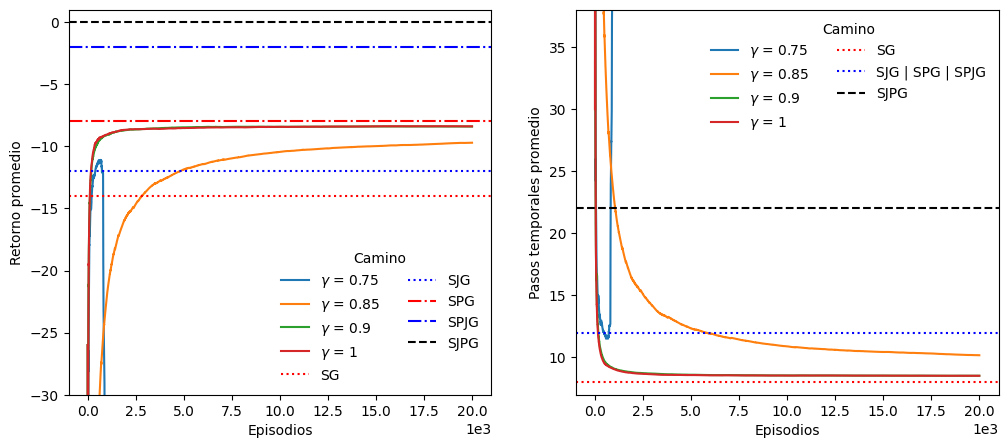

In [9]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))

# for p_s in [10, 20, 30, 40, 50, 60, 70]:
#     File = pd.read_csv(f'Outputs/Lab2/Dyna-Q/Steps/its-1000_eps-20000_a-0.1_g-1_e-0.05_s-{p_s}.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)
#     axs[0].plot(mean_evol(File[:,0]), label=rf'Plan = {p_s}')
#     axs[1].plot(mean_evol(File[:,1]), label=rf'Plan = {p_s}')

# for p_a in [0.05, 0.1, 0.15, 0.2, 0.25]:
#     File = pd.read_csv(f'Outputs/Lab2/Dyna-Q/Alpha/its-1000_eps-20000_a-{p_a}_g-1_e-0.05_s-10.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)
#     axs[0].plot(mean_evol(File[:,0]), label=rf'$\alpha$ = {p_a}')
#     axs[1].plot(mean_evol(File[:,1]), label=rf'$\alpha$ = {p_a}')

for p_g in [0.75, 0.85, 0.9, 1]:
    File = pd.read_csv(f'Outputs/Lab2/Dyna-Q/Gamma/its-1000_eps-20000_a-0.1_g-{p_g}_e-0.05_s-10.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)
    axs[0].plot(mean_evol(File[:,0]), label=rf'$\gamma$ = {p_g}')
    axs[1].plot(mean_evol(File[:,1]), label=rf'$\gamma$ = {p_g}')

# for p_t in [0.03, 0.05, 0.1, 0.5, 1]:
#     File = pd.read_csv(f'Outputs/Lab2/Dyna-Q/Tau/its-1000_eps-20000_a-0.1_g-0.45_t-{p_t}.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)
#     axs[0].plot(mean_evol(File[:,0]), label=rf'$\tau$ = {p_t}')
#     axs[1].plot(mean_evol(File[:,1]), label=rf'$\tau$ = {p_t}')

# for eps in [200000, 150000, 100000, 50000, 20000]:
#     File = pd.read_csv(f'Outputs/Lab2/Dyna-Q/Episodios/its-1000_eps-{eps}_a-0.1_g-0.45_t-0.03.csv', header=None, sep='\t').iloc[153:, :2].to_numpy().astype(int)
#     axs[0].plot(mean_evol(File[:,0]))
#     axs[1].plot(mean_evol(File[:,1]))

axs[0].set_ylim(-30, 1)
axs[1].set_ylim(7, 38)

axs[0].axhline(-14, color='red', linestyle=':', label='SG')
axs[0].axhline(-12, color='blue', linestyle=':', label='SJG')
axs[0].axhline(-8, color='red', linestyle='-.', label='SPG')
axs[0].axhline(-2, color='blue', linestyle='-.', label='SPJG')
axs[0].axhline(0, color='black', linestyle='--', label='SJPG')

axs[0].set_xlabel('Episodios')
axs[1].set_xlabel('Episodios')

axs[1].axhline(8, color='red', linestyle=':', label='SG')
axs[1].axhline(12, color='blue', linestyle=':', label='SJG | SPG | SPJG')
axs[1].axhline(22, color='black', linestyle='--', label='SJPG')

axs[0].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(3,3))

axs[0].set_ylabel('Retorno promedio')
axs[1].set_ylabel('Pasos temporales promedio')

axs[0].legend(loc='lower right', frameon=False, fancybox=True, title='Camino', ncol=2)
axs[1].legend(loc='upper right', frameon=False, fancybox=True, title='Camino', ncol=2)

# plt.savefig('Outputs/Lab2/Dyna-Q/Steps/its-1000_eps-20000_a-0.1_g-1_e-0.05.png')
# plt.savefig('Outputs/Lab2/Dyna-Q/Alpha/its-1000_eps-20000_g-1_e-0.05_s-10.png')
plt.savefig('Outputs/Lab2/Dyna-Q/Gamma/its-1000_eps-20000_a-0.1_e-0.05_s-10.png')
# plt.savefig('Outputs/Lab2/Dyna-Q/Tau/its-1000_eps-20000_a-0.1_g-0.45.png')
# plt.savefig('Outputs/Lab2/Dyna-Q/Episodios/its-1000_a-0.1_g-0.45_t-0.03.png')